# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import catboost as cb
import lightgbm as lgb
# To: install catboost
# !pip3 install catboost

from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt

# 1. Load Data

In [2]:
# Create a list to add csv files as df
Bldg = []

# Read all building data and append to list
for path in pathlib.Path("../Data/microclimate_model/Combined/dataset1").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg.append(current_file)
    

## 1.1 Preprocessing 

1. Adding Month, Hour, and Minute to data
2. Removing hours out of ENVI-met accuracy range (after 9 pm)
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx

In [3]:
# Create Month, Hour, and Minute column for all dataframes in list
for i in range(len(Bldg)):
    Bldg[i].Date_Time = pd.to_datetime(Bldg[i].Date_Time)
    Bldg[i]['Month_num'] = Bldg[i].Date_Time.dt.month
    Bldg[i]['Hour_num'] = Bldg[i].Date_Time.dt.hour
    Bldg[i]['Minute_num'] = Bldg[i].Date_Time.dt.minute
    Bldg[i]['Day_num'] = Bldg[i].Date_Time.dt.day

# Remove data after 9pm
for i in range(len(Bldg)):
    Bldg[i] = Bldg[i][(Bldg[i]['Hour_num'] <= 20) & (Bldg[i]['Hour_num'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg)):
    if Bldg[i]['bldgname'][0] in cond_area:
        Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]

<ipython-input-3-5f9eeec29275>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]


# 2. Single Building

## 2.1 Select Building

In [4]:
# Ask user to select building
for i in range(len(Bldg)):
    print(i, Bldg[i]['bldgname'][0])

bldgnum = int(input("Enter the number of the building from the list above: "))

Bldg[bldgnum].head()

0 Noble Library
1 Biodesign B
2 Biodesign C
3 Biodesign A
4 Psychology
5 Goldwater
6 Schwada COB
7 ISTB 2
8 Bulldog Hall
9 ISTB 4
10 Psychology North


Enter the number of the building from the list above:  0


,bldgname,Date,Time,Air Temp,Rel Hum,KW,CHWTON,HTmmBTU,Date_Time,Month_num,Hour_num,Minute_num,Day_num,CHWTON/SQFT
0,Noble Library,2018-05-16,05:00,23.516047,21.408253,151.53,61.60,-0.01,2018-05-16 05:00:00,5,5,0,16,0.000695
1,Noble Library,2018-05-16,05:15,22.987733,26.391075,153.91,65.59,-0.01,2018-05-16 05:15:00,5,5,15,16,0.000740
2,Noble Library,2018-05-16,05:30,22.796033,25.836088,151.04,63.87,-0.01,2018-05-16 05:30:00,5,5,30,16,0.000720
3,Noble Library,2018-05-16,05:45,22.718680,25.797224,152.13,65.71,-0.01,2018-05-16 05:45:00,5,5,45,16,0.000741
4,Noble Library,2018-05-16,06:00,22.609159,25.831215,148.10,61.55,-0.01,2018-05-16 06:00:00,5,6,0,16,0.000694


## 2.2 EDA

### 2.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 Day_num
13 CHWTON/SQFT


Enter the number of the following data columns to graph boxplot:  5



 Noble Library


<AxesSubplot:title={'center':'KW'}, xlabel='Hour_num'>

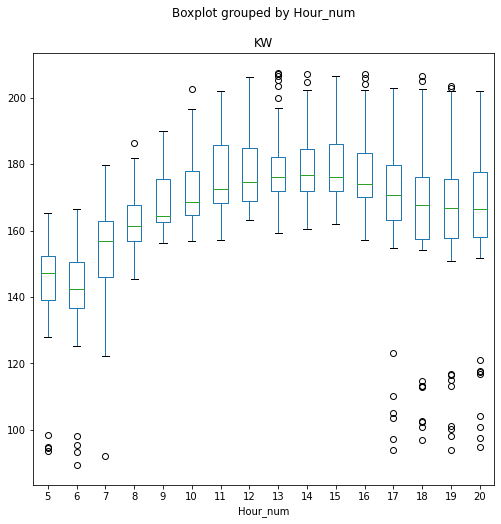

In [5]:
# Show df columns to select for boxplot
x = Bldg[bldgnum].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg[bldgnum]['bldgname'][0])
Bldg[bldgnum].boxplot(by='Hour_num', column=x[colname], grid = False, figsize = (8,8))

### 2.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25, 26<br>
August: 3, 27<br>
September: 11, 29<br>

In [ ]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg[bldgnum]['Month_num'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg[bldgnum][(Bldg[bldgnum]['Month_num'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 2.2.3 Correlation Matrix

In [ ]:
corr_pd = pd.DataFrame(Bldg[bldgnum][['Time','Air Temp','Rel Hum','KW','HTmmBTU','Month_num','Hour_num','Day_num', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)


## 2.3 Random Forest without tuning

In [ ]:
# drop na values if in dataframe
if (Bldg[bldgnum].isnull().values.any() == True):
    Bldg[bldgnum] = Bldg[bldgnum].dropna()
    
# split data into X and y
X = Bldg[bldgnum].drop(columns=['KW',
                                'CHWTON/SQFT',
                                'CHWTON',
                                'Month_num',
                                'Minute_num',
                                'Day_num',
                                'Date_Time',
                                'Date',
                                'Time',
                                'bldgname',
                                'HTmmBTU'])
y = Bldg[bldgnum]['CHWTON/SQFT']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Set up model. Number of trees 100
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train data
base_RF.fit(X_train, y_train)

# Get prediction
y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

score = base_RF.score(X_test, y_test)
rf_score = pd.DataFrame({"bldgname": Bldg[bldgnum]['bldgname'].unique()[0], "test score (on 20% of data)": [score]})
rf_score

# 3. All Buildings

## 3.1 EDA

### 3.1.1 Boxplots

In [6]:
# Create List of building names so we can extract the name easily 
BldgName = ["Noble Library","Biodesign B","Biodesign C",
              "Biodesign A", "Psychology", "Goldwater",
              "Schwada COB", "ISTB 2", "Bulldog Hall",
              "ISTB 4", "Pyschology North"]


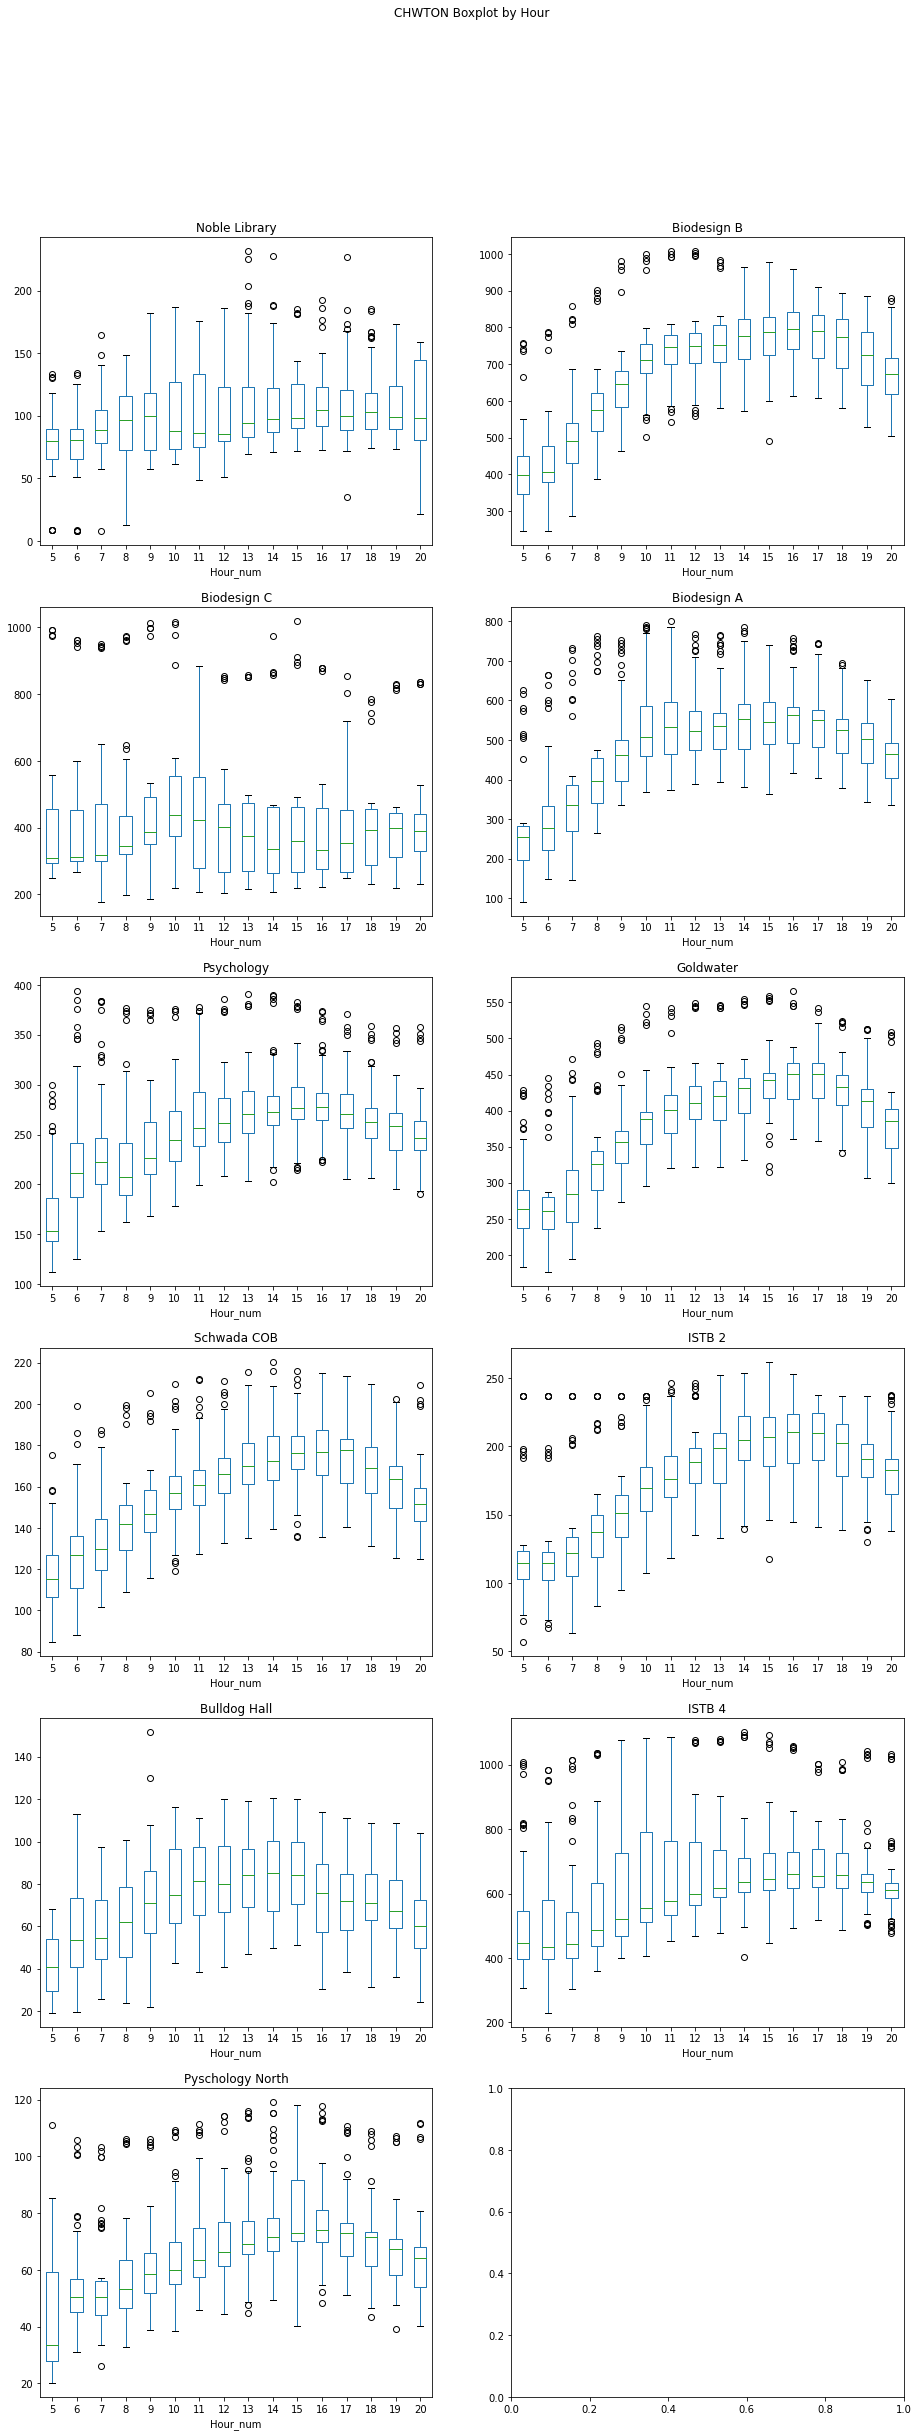

In [7]:
#Create CHWTON boxplots for all buildings #
def createBoxPlot(df, columnName, BldgName):
    row_size = 6
    column_size = 2
    fig, ax = plt.subplots(row_size, column_size, figsize = (15,40))

    i = 0
    while i < (len(df)):
        for row in range(row_size):
            for col in range(column_size):
                if i < len(df):
                    df[i].boxplot(by='Hour_num',
                                    column=[columnName],
                                    grid = False,
                                    figsize = (5,5),
                                    ax = ax[row,col] )
                    ax[row,col].title.set_text(BldgName[i])
                    i += 1

    fig.suptitle(columnName + ' Boxplot by Hour')
    plt.show()
    
createBoxPlot(Bldg, 'CHWTON', BldgName)

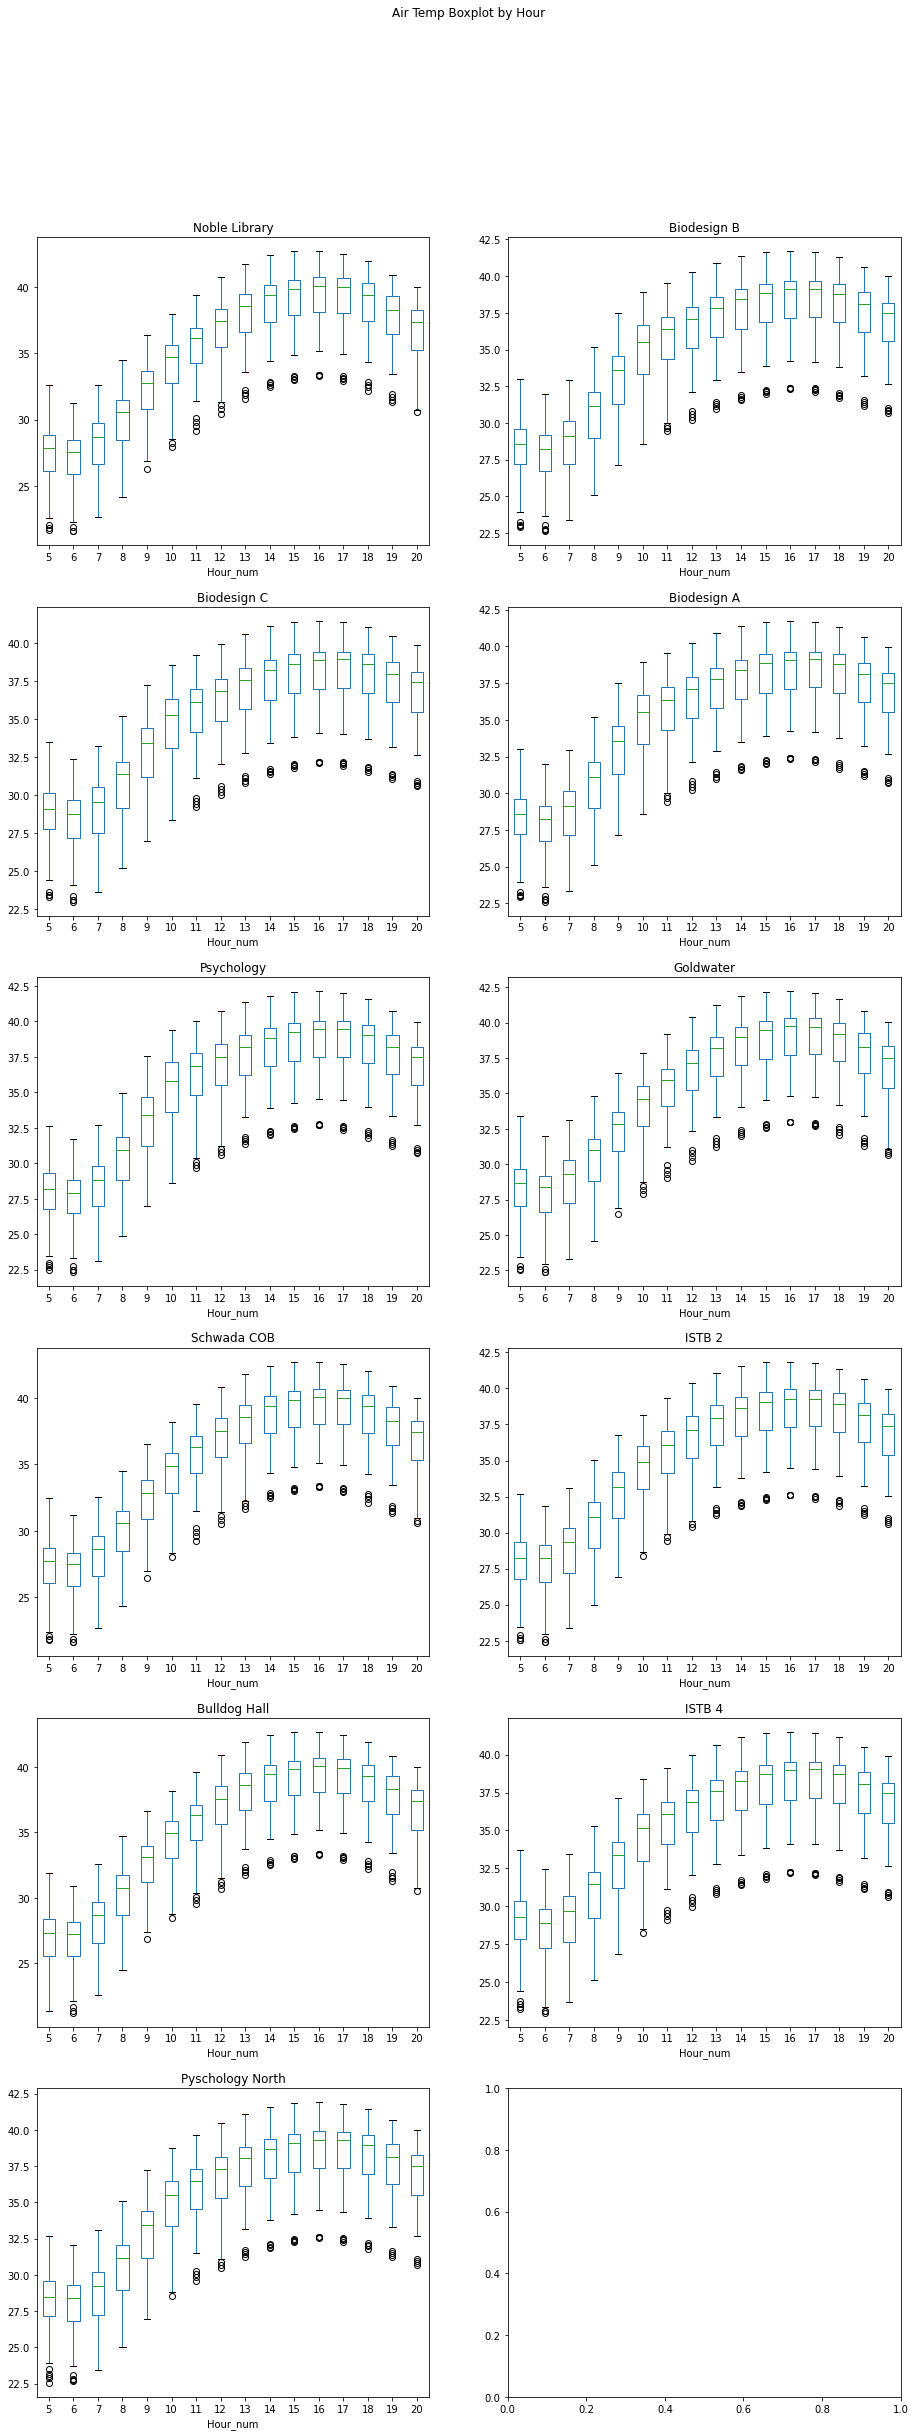

In [8]:
createBoxPlot(Bldg, 'Air Temp', BldgName)

### 3.1.2 Time Series

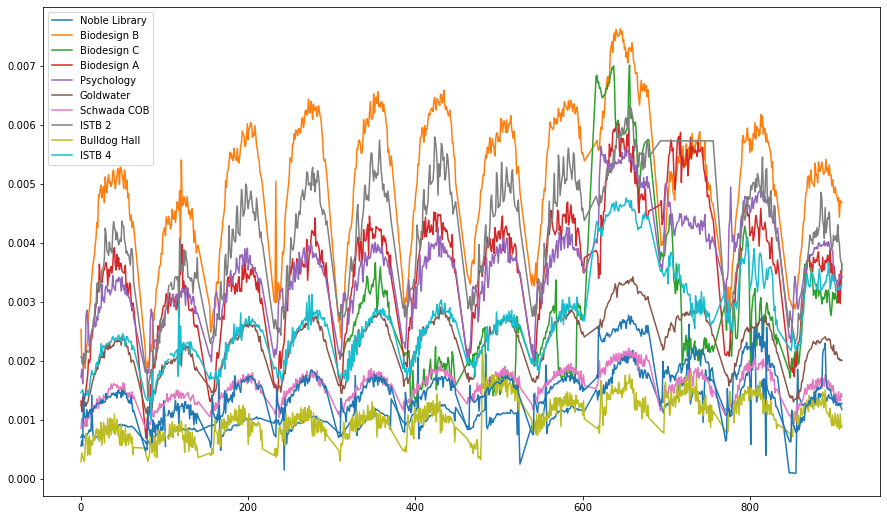

In [9]:
## Print CHWTON/SQFT for all buildings and all timestamps in data
ax = Bldg[0]['CHWTON/SQFT'].plot(figsize = (15,9))
legendlabels = []
for i in range(len(Bldg)-1):
    Bldg[i+1]['CHWTON/SQFT'].plot(ax=ax)
    legendlabels.append(Bldg[i].bldgname[0])
    
ax.legend(labels = legendlabels)


## 3.2 Feature Engineering

In [10]:
# function to encode df columns into sine and cosine
def encode(df, col, max_val):
    df[col.replace('_num', '') + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col.replace('_num', '') + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop(columns = [col], inplace = True)
    return df


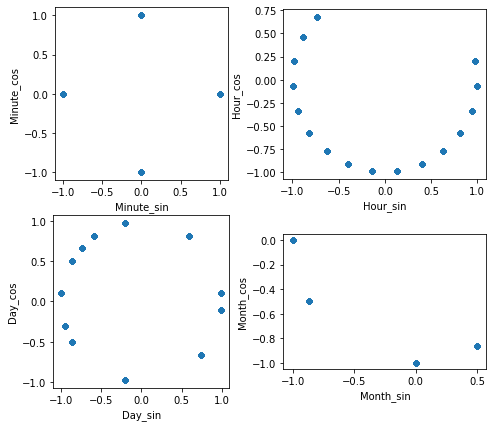

In [11]:
# create a list of df for buildings with cyclical time features
Bldg_cyclic = []

for i in range(len(Bldg)):
    Bldg_enc = Bldg[i].copy(deep = True)
    Bldg_enc = encode(Bldg_enc, 'Minute_num', 60.0)
    Bldg_enc = encode(Bldg_enc, 'Hour_num', 23.0)
    Bldg_enc = encode(Bldg_enc, 'Day_num', 30.0)
    Bldg_enc = encode(Bldg_enc, 'Month_num', 12.0)
    Bldg_cyclic.append(Bldg_enc)
    
# Plot cyclical features sample
fig, ax = plt.subplots(2,2, figsize = (8,7))
Bldg_cyclic[0].plot.scatter('Minute_sin', 'Minute_cos', ax = ax[0,0]).set_aspect('equal')
Bldg_cyclic[0].plot.scatter('Hour_sin', 'Hour_cos', ax = ax[0,1]).set_aspect('equal')
Bldg_cyclic[0].plot.scatter('Day_sin', 'Day_cos', ax = ax[1,0]).set_aspect('equal')
Bldg_cyclic[0].plot.scatter('Month_sin', 'Month_cos', ax = ax[1,1]).set_aspect('equal')

## 3.3 Modelling set up

In [12]:
### Create scores dataframe and add building names ###
scores_df = pd.DataFrame(columns = {"bldgname"})
for i in range(len(Bldg)):
    scores_df = scores_df.append({'bldgname': BldgName[i]}, ignore_index=True)


In [13]:
# function to train a model and get its scores
def trainAndGetScore(pModel, pModelName, pDf_all_bldg, pDf_scores):
    for i in range(len(pDf_all_bldg)):
        # 1. drop na values if in dataframe
        if (pDf_all_bldg[i].isnull().values.any() == True):
            pDf_all_bldg[i] = pDf_all_bldg[i].dropna()
            
        # 2. split data into X and y
        X = pDf_all_bldg[i].drop(columns=['Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'CHWTON/SQFT'])
        y = pDf_all_bldg[i]['CHWTON']    
        
        # 3. Train-Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
        
        # 4. fit model that already has parameters
        pModel.fit(X_train, y_train)
        
        # 5. Get prediction
        y_pred = pModel.predict(X_test)
        ModelPred = pd.DataFrame({'Actual CHWTON':y_test, 'Predicted CHWTON':y_pred})
        ModelPred = ModelPred.sort_index()
    
        # 6. Get best params if it's a random or grid search
        if("random" in pModelName) or ("grid" in pModelName):
            print(pModel.best_estimator_.get_params())
        
        # Save scores
        score = pModel.score(X_test, y_test)
        pDf_scores.loc[i,pModelName] = score

## 3.4 Model 1: Random Forest


### 3.4.1 No Tuning

In [14]:
RF_base = RandomForestRegressor(n_estimators = 100, random_state = 42)

# 1. Base RF on base data
trainAndGetScore(RF_base, "RF_base", Bldg, scores_df)

# 2. Base RF on cyclical time features
trainAndGetScore(RF_base, "RF_cyclic", Bldg_cyclic, scores_df)


### 3.4.2 Random Search Tuning

In [15]:
# Define parameters for RF

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [16]:
# 1. Set parameters on random_RF
RF_random = RandomizedSearchCV(estimator = RF_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_random, "RF_random", Bldg, scores_df)

# 3. Train on data with cyclical time features
trainAndGetScore(RF_random, "RF_random_cyclic", Bldg_cyclic, scores_df)
scores_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.2s finished


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.3s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.3s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.6s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.5s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 60, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.9s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 60, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 60, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.3s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.0s finished


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.8s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.1s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.5s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 110, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.4s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.5s finished


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 60, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.6s finished


{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


,bldgname,RF_base,RF_cyclic,RF_random,RF_random_cyclic
0,Noble Library,0.820427,0.825633,0.825529,0.829439
1,Biodesign B,0.975534,0.972561,0.977302,0.976477
2,Biodesign C,0.973916,0.972591,0.974402,0.975998
3,Biodesign A,0.965788,0.969239,0.969848,0.974834
4,Psychology,0.972261,0.971104,0.972971,0.974026
5,Goldwater,0.983556,0.980592,0.984520,0.985207
6,Schwada COB,0.931360,0.929065,0.934264,0.934495
7,ISTB 2,0.975108,0.974418,0.975669,0.975623
8,Bulldog Hall,0.728545,0.738526,0.766687,0.764758
9,ISTB 4,0.978601,0.976439,0.975294,0.972583


In [17]:
print(RF_random.best_estimator_.get_params())

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### 3.4.3 Grid Search Tuning

In [18]:
param_grid = {'n_estimators': [200, 220, 230,240],
               'max_features': ["sqrt"],
               'max_depth': [17, 20, 22],
               'min_samples_split': [2,3,4],
               'min_samples_leaf': [ 1, 2],
               'bootstrap': bootstrap}

In [19]:
# 1. Set parameters on random_RF
RF_grid = GridSearchCV(estimator = RF_base,
                       param_grid = param_grid,
                       cv = 5,
                       scoring ='r2',
                       n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_grid, "RF_grid", Bldg, scores_df)

# 3. Train on data with cyclical time features
trainAndGetScore(RF_grid, "RF_grid_cyclic", Bldg_cyclic, scores_df)
scores_df

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 22, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 230, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 17, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_sa

,bldgname,RF_base,RF_cyclic,RF_random,RF_random_cyclic,RF_grid,RF_grid_cyclic
0,Noble Library,0.820427,0.825633,0.825529,0.829439,0.803960,0.843947
1,Biodesign B,0.975534,0.972561,0.977302,0.976477,0.976834,0.976329
2,Biodesign C,0.973916,0.972591,0.974402,0.975998,0.974146,0.975799
3,Biodesign A,0.965788,0.969239,0.969848,0.974834,0.969779,0.973368
4,Psychology,0.972261,0.971104,0.972971,0.974026,0.973329,0.974038
5,Goldwater,0.983556,0.980592,0.984520,0.985207,0.984641,0.985407
6,Schwada COB,0.931360,0.929065,0.934264,0.934495,0.934602,0.932118
7,ISTB 2,0.975108,0.974418,0.975669,0.975623,0.975438,0.975732
8,Bulldog Hall,0.728545,0.738526,0.766687,0.764758,0.760792,0.755317
9,ISTB 4,0.978601,0.976439,0.975294,0.972583,0.976877,0.975512


## 3.5 Model 2: XGBoost

### 3.5.1. No Tuning

In [20]:
# 1. create base model
XGB_base = XGBRegressor(n_estimators = 100, random_state = 42)

# 2. Base XGB on base data
trainAndGetScore(XGB_base, "XGB_base", Bldg, scores_df)

# 3. Base XGB on cyclica time features
trainAndGetScore(XGB_base, "XGB_cyclic", Bldg_cyclic, scores_df)
scores_df

,bldgname,RF_base,RF_cyclic,RF_random,RF_random_cyclic,RF_grid,RF_grid_cyclic,XGB_base,XGB_cyclic
0,Noble Library,0.820427,0.825633,0.825529,0.829439,0.803960,0.843947,0.702260,0.712644
1,Biodesign B,0.975534,0.972561,0.977302,0.976477,0.976834,0.976329,0.968222,0.968990
2,Biodesign C,0.973916,0.972591,0.974402,0.975998,0.974146,0.975799,0.967246,0.971601
3,Biodesign A,0.965788,0.969239,0.969848,0.974834,0.969779,0.973368,0.964592,0.973596
4,Psychology,0.972261,0.971104,0.972971,0.974026,0.973329,0.974038,0.964963,0.969722
5,Goldwater,0.983556,0.980592,0.984520,0.985207,0.984641,0.985407,0.981092,0.980374
6,Schwada COB,0.931360,0.929065,0.934264,0.934495,0.934602,0.932118,0.921814,0.916945
7,ISTB 2,0.975108,0.974418,0.975669,0.975623,0.975438,0.975732,0.973945,0.975297
8,Bulldog Hall,0.728545,0.738526,0.766687,0.764758,0.760792,0.755317,0.725459,0.710538
9,ISTB 4,0.978601,0.976439,0.975294,0.972583,0.976877,0.975512,0.974632,0.967943


### 3.5.2. Random Search Tuning

In [22]:
# 1. Define grid
params = {
    'n_estimators':[ 100, 250, 500, 1000],
    'min_child_weight':[4,5,8], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

# 2. Set up model with grid
n_iter_search = 20
XGB_random = RandomizedSearchCV(XGB_base,
                                param_distributions = params,
                                n_iter = n_iter_search,
                                cv = 5,
                                verbose = 2,
                                random_state = 42,
                                scoring ='r2',
                                n_jobs = -1)

# 2. Train on base data
trainAndGetScore(XGB_random, "XGB_random", Bldg, scores_df)

# 3. Train on data with cyclical time features
trainAndGetScore(XGB_random, "XGB_random_cyclic", Bldg_cyclic, scores_df)
scores_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished


[12:04:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'objective': 'reg:tweedie', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse'

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[12:04:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'objective': 'reg:tweedie', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'val

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.5}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.5}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.5}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.6, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.3}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.4s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.5}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[12:05:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'objective': 'reg:tweedie', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse'

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[12:06:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'objective': 'reg:tweedie', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.4, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse'

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.4s finished


{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 4, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'rmse', 'eta': 0.5}


,bldgname,RF_base,RF_cyclic,RF_random,RF_random_cyclic,RF_grid,RF_grid_cyclic,XGB_base,XGB_cyclic,XGB_random,XGB_random_cyclic
0,Noble Library,0.820427,0.825633,0.825529,0.829439,0.803960,0.843947,0.702260,0.712644,0.774403,0.723992
1,Biodesign B,0.975534,0.972561,0.977302,0.976477,0.976834,0.976329,0.968222,0.968990,0.972289,0.970512
2,Biodesign C,0.973916,0.972591,0.974402,0.975998,0.974146,0.975799,0.967246,0.971601,0.972138,0.973486
3,Biodesign A,0.965788,0.969239,0.969848,0.974834,0.969779,0.973368,0.964592,0.973596,0.977548,0.972333
4,Psychology,0.972261,0.971104,0.972971,0.974026,0.973329,0.974038,0.964963,0.969722,0.966554,0.970162
5,Goldwater,0.983556,0.980592,0.984520,0.985207,0.984641,0.985407,0.981092,0.980374,0.983081,0.983268
6,Schwada COB,0.931360,0.929065,0.934264,0.934495,0.934602,0.932118,0.921814,0.916945,0.932686,0.932861
7,ISTB 2,0.975108,0.974418,0.975669,0.975623,0.975438,0.975732,0.973945,0.975297,0.967872,0.970226
8,Bulldog Hall,0.728545,0.738526,0.766687,0.764758,0.760792,0.755317,0.725459,0.710538,0.744485,0.745553
9,ISTB 4,0.978601,0.976439,0.975294,0.972583,0.976877,0.975512,0.974632,0.967943,0.975926,0.973153


### 3.5.3 Bayesian Opt. tuning

In [ ]:
# from bayes_opt import BayesianOptimization


# for i in range(len(Bldg)):
#         # 1. drop na values if in dataframe
#         if (Bldg[i].isnull().values.any() == True):
#             Bldg[i] = pDf_all_bldg[i].dropna()
            
#         # 2. split data into X and y
#         X = Bldg[i].drop(columns=['Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'CHWTON/SQFT'])
#         y = Bldg[i]['CHWTON']    
        
#         # 3. Train-Test Split
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    
# # 1. Function to maximimse score 
# # This function will take the the parameters we defined and obtain a score
# def train_XGB(max_depth, gamma, n_estimators, learning_rate, subsample):
#     params_XGB = {}
#     params_XGB['max_depth'] = round(max_depth)
#     params_XGB['gamma'] = gamma
#     params_XGB['learning_rate'] = learning_rate
#     params_XGB['n_estimators'] = round(n_estimators)
#     params_XGB['subsample'] = subsample
#     scores = cross_val_score(XGBRegressor(random_state=42, **params_XGB),
#                              X_train, y_train, scoring='r2', cv=5).mean()
#     score = scores.mean()
#     return score
               
               
               
# params_XGB ={
#     'max_depth':(3, 10),
#     'gamma':(0, 1),
#     'learning_rate':(0.01, 1),
#     'n_estimators':(80, 150),
#     'subsample': (0.8, 1)
# }
# XGB_bayes = BayesianOptimization(train_XGB, params_XGB, random_state=111)
# XGB_bayes.maximize(init_points=20, n_iter=10)
# print('It takes %s minutes' % ((time.time() - start)/60))

## 3.6 Model 3: LightGBM

### 3.6.1 No Tuning

In [23]:
LGBM_base = lgb.LGBMRegressor(random_state = 42)

# 2. Base LGBM on base data
trainAndGetScore(LGBM_base, "LGBM_base", Bldg, scores_df)

# 3. Base LGBM on cyclica time features
trainAndGetScore(LGBM_base, "LGBM_cylic", Bldg_cyclic, scores_df)
scores_df

,bldgname,RF_base,RF_cyclic,RF_random,RF_random_cyclic,RF_grid,RF_grid_cyclic,XGB_base,XGB_cyclic,XGB_random,XGB_random_cyclic,LGBM_base,LGBM_cylic
0,Noble Library,0.820427,0.825633,0.825529,0.829439,0.803960,0.843947,0.702260,0.712644,0.774403,0.723992,0.822775,0.804486
1,Biodesign B,0.975534,0.972561,0.977302,0.976477,0.976834,0.976329,0.968222,0.968990,0.972289,0.970512,0.976992,0.974523
2,Biodesign C,0.973916,0.972591,0.974402,0.975998,0.974146,0.975799,0.967246,0.971601,0.972138,0.973486,0.970892,0.970775
3,Biodesign A,0.965788,0.969239,0.969848,0.974834,0.969779,0.973368,0.964592,0.973596,0.977548,0.972333,0.970895,0.971035
4,Psychology,0.972261,0.971104,0.972971,0.974026,0.973329,0.974038,0.964963,0.969722,0.966554,0.970162,0.973962,0.971714
5,Goldwater,0.983556,0.980592,0.984520,0.985207,0.984641,0.985407,0.981092,0.980374,0.983081,0.983268,0.985338,0.983215
6,Schwada COB,0.931360,0.929065,0.934264,0.934495,0.934602,0.932118,0.921814,0.916945,0.932686,0.932861,0.936497,0.933492
7,ISTB 2,0.975108,0.974418,0.975669,0.975623,0.975438,0.975732,0.973945,0.975297,0.967872,0.970226,0.970493,0.971726
8,Bulldog Hall,0.728545,0.738526,0.766687,0.764758,0.760792,0.755317,0.725459,0.710538,0.744485,0.745553,0.725461,0.751614
9,ISTB 4,0.978601,0.976439,0.975294,0.972583,0.976877,0.975512,0.974632,0.967943,0.975926,0.973153,0.974264,0.974084


### 3.6.2 Random Search Tuning

In [24]:
# 1. Define grid
random_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

# 2. Set up model with grid
LGBM_random = RandomizedSearchCV(estimator = LGBM_base,
                                 param_distributions = random_grid, 
                                 n_iter = 100, cv = 2,
                                 scoring='r2',
                                 verbose= 2,
                                 random_state= 42,
                                 n_jobs = -1)


In [25]:
# 3. Base LGBM on base data
trainAndGetScore(LGBM_random, "LGBM_random", Bldg, scores_df)

# 4. Base LGBM on cyclica time features
trainAndGetScore(LGBM_random, "LGBM_random_cyclic", Bldg_cyclic, scores_df)
scores_df

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 28, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 14, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 28, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.5s finished


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 21, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 21, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 28, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.1s finished


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 14, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 14, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 28, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.4s finished


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 14, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 28, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 21, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.2s finished


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 7, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


,bldgname,RF_base,RF_cyclic,RF_random,RF_random_cyclic,RF_grid,RF_grid_cyclic,XGB_base,XGB_cyclic,XGB_random,XGB_random_cyclic,LGBM_base,LGBM_cylic,LGBM_random,LGBM_random_cyclic
0,Noble Library,0.820427,0.825633,0.825529,0.829439,0.803960,0.843947,0.702260,0.712644,0.774403,0.723992,0.822775,0.804486,0.822027,0.800978
1,Biodesign B,0.975534,0.972561,0.977302,0.976477,0.976834,0.976329,0.968222,0.968990,0.972289,0.970512,0.976992,0.974523,0.977018,0.976422
2,Biodesign C,0.973916,0.972591,0.974402,0.975998,0.974146,0.975799,0.967246,0.971601,0.972138,0.973486,0.970892,0.970775,0.973443,0.973249
3,Biodesign A,0.965788,0.969239,0.969848,0.974834,0.969779,0.973368,0.964592,0.973596,0.977548,0.972333,0.970895,0.971035,0.977086,0.976958
4,Psychology,0.972261,0.971104,0.972971,0.974026,0.973329,0.974038,0.964963,0.969722,0.966554,0.970162,0.973962,0.971714,0.975449,0.978292
5,Goldwater,0.983556,0.980592,0.984520,0.985207,0.984641,0.985407,0.981092,0.980374,0.983081,0.983268,0.985338,0.983215,0.986288,0.984108
6,Schwada COB,0.931360,0.929065,0.934264,0.934495,0.934602,0.932118,0.921814,0.916945,0.932686,0.932861,0.936497,0.933492,0.939726,0.940108
7,ISTB 2,0.975108,0.974418,0.975669,0.975623,0.975438,0.975732,0.973945,0.975297,0.967872,0.970226,0.970493,0.971726,0.974859,0.971370
8,Bulldog Hall,0.728545,0.738526,0.766687,0.764758,0.760792,0.755317,0.725459,0.710538,0.744485,0.745553,0.725461,0.751614,0.761165,0.754882
9,ISTB 4,0.978601,0.976439,0.975294,0.972583,0.976877,0.975512,0.974632,0.967943,0.975926,0.973153,0.974264,0.974084,0.972383,0.974478


### 3.6.3 Bayesian Opt. tuning

In [ ]:
# cv_results = lgb.cv(
#         params,
#         dftrainLGB,
#         num_boost_round=100,
#         nfold=3,
#         metrics='mae',
#         early_stopping_rounds=10,
#         stratified=False
#         )